# Deterministic Pursuit-Only Dynamics

- The predator accelerates in a straight line towards the prey
- The predator has higher speed than the prey

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

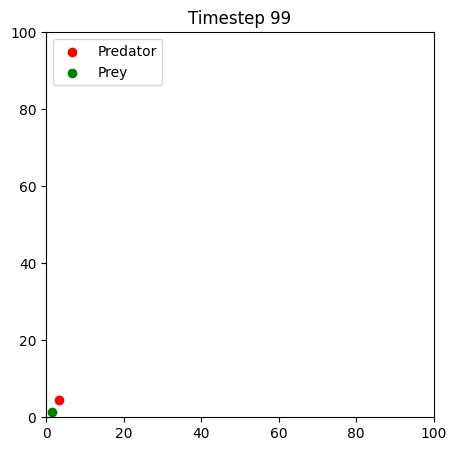

In [2]:
# --- 1) PARAMETERS ---------------------------------------------------
dt       = 1.0       # your timestep
n_steps  = 100       # number of frames
bounds   = (0, 100)  # plotting limits [min, max] on both axes
pred_maxspeed = 3

# --- 2) INITIALIZE STATE TENSOR --------------------------------------
# agents indexed 0=predator, 1=prey; features 0=pos,1=vel,2=acc; dims 2D
state = np.zeros((2, 3, 2), dtype=float)

# give predator some initial pos, vel, acc
state[0, 0] = [10, 10]    # predator.pos
state[0, 1] = [ 1,  0.5]  # predator.vel
state[0, 2] = [ 0, -0.01] # predator.acc

# give prey some initial pos, vel, acc
state[1, 0] = [20, 50]   # prey.pos
state[1, 1] = [-0.5, -0.5] # prey.vel
state[1, 2] = [   0,  0] # prey.acc

def step(state, dt):
    """
    state: (2 agents, 3 features, 2 dims)
    features are [pos, vel, acc]; we want
      pos += vel * dt
      vel += acc * dt
    """
    # adds dt * vel to both pos and vel-update (pos += vel*dt, vel += acc*dt)
    state[:, :2, :] += dt * state[:, 1:, :]
    return state

def handle_boundaries(state, bounds):
    """
    Check if agents hit boundaries and reverse their direction if so
    """
    min_bound, max_bound = bounds

    # For each agent
    for agent in range(2):

        # Check x-boundaries
        if state[agent, 0, 0] <= min_bound:
            state[agent, 0, 0] = min_bound + 1  # Move agent slightly inside boundary
            state[agent, 1, 0] *= -1  # Reverse x velocity
        elif state[agent, 0, 0] >= max_bound:
            state[agent, 0, 0] = max_bound - 1
            state[agent, 1, 0] *= -1
            
        # Check y-boundaries
        if state[agent, 0, 1] <= min_bound:
            state[agent, 0, 1] = min_bound + 1
            state[agent, 1, 1] *= -1  # Reverse y velocity
        elif state[agent, 0, 1] >= max_bound:
            state[agent, 0, 1] = max_bound - 1
            state[agent, 1, 1] *= -1
    
    return state

def normalize(v):
    length = np.linalg.norm(v)
    if length == 0:
        return np.zeros_like(v)
    return v / length

def chase(state, max_speed=2.0, max_force=0.1):
    direction = state[1, 0] - state[0, 0]
    velocity = normalize(direction) * max_speed

    steering = velocity - state[0, 1]
    
    # Clamp steering to max_force
    steering_norm = np.linalg.norm(steering)
    if steering_norm > max_force:
        steering = steering / steering_norm * max_force

    state[0, 2] = steering

# --- 3) RUN & PLOT LOOP ----------------------------------------------
for _ in range(n_steps):
    # 1) vectorized update
    state = step(state, dt)

    # 2) handle boundary collisions
    state = handle_boundaries(state, bounds)

    # 3) collision check: if predator pos == prey pos?
    distance = np.linalg.norm(state[0, 0] - state[1, 0])
    if distance < 3.0: #capture threshold
        # “capture” event:
        state[1, 0] = [-1, -1]
        state[0,1] = [0, 0]   # predator stops moving

    # 4) chase
    chase(state)

    # 5) unpack for plotting
    pred_x, pred_y = state[0,0]
    prey_x, prey_y = state[1,0]

    # 6) draw
    clear_output(wait=True)
    plt.figure(figsize=(5,5))
    plt.xlim(*bounds)
    plt.ylim(*bounds)
    plt.scatter(pred_x, pred_y, color='red',   label='Predator')
    plt.scatter(prey_x, prey_y, color='green', label='Prey')
    plt.legend(loc='upper left')
    plt.title("Timestep %d" % _)
    plt.show()

    time.sleep(0.2)
